In [3]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd
from bs4 import BeautifulSoup
import requests
from datetime import datetime

In [4]:
url = 'https://en.wikipedia.org/wiki/List_of_best-selling_manga'

page = requests.get(url)
current_time = datetime.now()
soup=BeautifulSoup(page.text, 'html')

In [5]:
table1=soup.find_all('table',class_='wikitable sortable')[1]
table2=soup.find_all('table',class_='wikitable sortable')[2]

Cleaning up the HTML tags before they're put into tables

In [6]:
for br in table1("br"):
    br.replace_with(" ")
for sup in table1("sup"):
    sup.replace_with("")
    
for br in table2("br"):
    br.replace_with(" ")
for sup in table2("sup"):
    sup.replace_with("")

In [7]:
world_titles1=table1.find_all('th')
world_titles2=table2.find_all('th')

In [8]:
#allows us to make the column titles correctly formatted
world_table_titles1=[title.text.replace(' ','_').strip() for title in world_titles1]
world_table_titles2=[title.text.replace(' ','_').strip() for title in world_titles2]

In [9]:
df1 = pd.DataFrame(columns=world_table_titles1)
df2 = pd.DataFrame(columns=world_table_titles2)

In [10]:
#names of columns is in tr tags, we get it using the following code
column_data = table1.find_all('tr')
column_data2 = table2.find_all('tr')

For each table adds all the content of the table and adds it to the data frame row by row

In [11]:
for row in column_data[1:]:
    row_data = row.find_all('td')
    individual_row_data = [data.text.strip() for data in row_data]

    length=len(df1)
    df1.loc[length] = individual_row_data

for row in column_data2[1:]:
    row_data = row.find_all('td')
    individual_row_data = [data.text.strip() for data in row_data]

    length=len(df2)
    df2.loc[length] = individual_row_data

In [12]:
#joins the two tables
df = pd.concat([df1, df2], axis=0, ignore_index=True)

In [13]:
df

,Manga_series,Author(s),Publisher,Demographic,No._of_collected_volumes,Serialized,Approximate_sales,Average_sales_per_volume
0,Captain Tsubasa,Yōichi Takahashi,Shueisha,Shōnen/Seinen,108,1981–present,90 million†,0.83 million
1,Jujutsu Kaisen,Gege Akutami,Shueisha,Shōnen,26,2018–present,90 million†‡,3.4 million
2,Sazae-san,Machiko Hasegawa,Kodansha,—,45,1946–1974,86 million,1.91 million
3,Hunter × Hunter,Yoshihiro Togashi,Shueisha,Shōnen,37,1998–present (on hiatus),84 million†‡,2.33 million
4,Vagabond,Takehiko Inoue,Kodansha,Seinen,37,1998–2015 (on hiatus),82 million,2.21 million
...,...,...,...,...,...,...,...,...
86,Tokimeki Tonight,Koi Ikeno,Shueisha,Shōjo,30,1982–1994,30 million†,1.00 million
87,Toriko,Mitsutoshi Shimabukuro,Shueisha,Shōnen,43,2008–2016,30 million†,0.69 million
88,Ushio and Tora,Kazuhiro Fujita,Shogakukan,Shōnen,33,1990–1996,30 million†,0.90 million
89,Yawara!,Naoki Urasawa,Shogakukan,Seinen,29,1986–1993,30 million†,1.03 million


Code is used to create a column which states if the manga has gone on hiatus

In [14]:
hiatus=[]

for i in range(len(df['Serialized'])):
    #checks if the serialized data has the word hiatus in it and depending on this will either set the row to true or false
    if df['Serialized'].str.contains("hiatus")[i]==True:
        hiatus.append(True)
    else:
        hiatus.append(False)
#adds the column to the 6th index with the name 'Hiatus'
df.insert(6,'Hiatus',hiatus,True)

The following section will clean data in the dataframe

In [15]:
#removes cell 5 as it's publisher isn't useful and it alone isn't significant enough to clean as it's a problem unique to that row
df.drop(5, axis=0, inplace=True)
df.drop(2, axis=0, inplace=True)
df.reset_index(drop=True,inplace=True)

In [16]:
#removing the crosses from the sales so that further cleaning can be done
df['Approximate_sales']=df['Approximate_sales'].str.strip('†‡')

#cleans the Serialized column and ensures it only includes the start and end date
df['Serialized']=df['Serialized'].str.replace('present', current_time.strftime('%Y'))
df['Serialized']=df['Serialized'].str.rstrip(' (on hiatus)')

#replaces the any - which represent an empty cell with a blank string
df['Demographic']=df['Demographic'].str.replace('—','Na')

#removes the million from the sales columns
df['Approximate_sales']=df['Approximate_sales'].str.rstrip(' million')
df['Average_sales_per_volume']=df['Average_sales_per_volume'].str.rstrip(' million')

#splits any cells in the volumes and demographic section which have a content that aren't just one value and fixes it
df['No._of_collected_volumes'] = df['No._of_collected_volumes'].str.split('/').str[0]
df['Demographic'] = df['Demographic'].str.split('/').str[0]

#converts the string values into floats and integers so that analysis can be performed
df['Approximate_sales']=df['Approximate_sales'].astype(float)
df['Average_sales_per_volume']=df['Average_sales_per_volume'].astype(float)
df['No._of_collected_volumes']=df['No._of_collected_volumes'].astype(int)

#ensures that the values which were originally in the millions is in the millions
df['Approximate_sales']=df['Approximate_sales'].mul(1000000)
df['Average_sales_per_volume']=df['Average_sales_per_volume'].mul(1000000)

In [17]:
df

,Manga_series,Author(s),Publisher,Demographic,No._of_collected_volumes,Serialized,Hiatus,Approximate_sales,Average_sales_per_volume
0,Captain Tsubasa,Yōichi Takahashi,Shueisha,Shōnen,108,1981–2024,False,90000000.0,830000.0
1,Jujutsu Kaisen,Gege Akutami,Shueisha,Shōnen,26,2018–2024,False,90000000.0,3400000.0
2,Hunter × Hunter,Yoshihiro Togashi,Shueisha,Shōnen,37,1998–2024,True,84000000.0,2330000.0
3,Vagabond,Takehiko Inoue,Kodansha,Seinen,37,1998–2015,True,82000000.0,2210000.0
4,Sangokushi,Mitsuteru Yokoyama,Ushio Shuppansha,Shōnen,60,1971–1986,False,80000000.0,1330000.0
...,...,...,...,...,...,...,...,...,...
84,Tokimeki Tonight,Koi Ikeno,Shueisha,Shōjo,30,1982–1994,False,30000000.0,1000000.0
85,Toriko,Mitsutoshi Shimabukuro,Shueisha,Shōnen,43,2008–2016,False,30000000.0,690000.0
86,Ushio and Tora,Kazuhiro Fujita,Shogakukan,Shōnen,33,1990–1996,False,30000000.0,900000.0
87,Yawara!,Naoki Urasawa,Shogakukan,Seinen,29,1986–1993,False,30000000.0,1030000.0


In [18]:
class analysis:
    def __init__(self, data):
        """" this function will be used to set the data up"""
        self.data=data

    def top_mangas_publisher(self):
        """ this function will be made to return the top publishers based on the approximate sales they make"""
        max_sales = self.data['Approximate_sales'].max()
        top_publishers = self.data[self.data['Approximate_sales'] == max_sales]['Publisher'].unique()
        return top_publishers.tolist()
    
    def volumes_hiatus_rel(self):
        """ this will try to statistically describe the relationship between the number of volumes a manga has and the chance it's on hiatus"""
        hiatus=self.data[self.data['Hiatus']==True]
        no_hiatus=self.data[self.data['Hiatus']==False]
        return f"the average value of volumes for manga that have been on hiatus is {round(hiatus['No._of_collected_volumes'].mean(),2)} and for those without it was {round(no_hiatus['No._of_collected_volumes'].mean(),2)}"
    
    def hiatus_pie_chart(self):
        """this will return a pie chart of the amount of series that are on hiatus vs the amount of series that aren't"""

        on_hiatus_count = self.data[self.data['Hiatus'] == True].shape[0]
        not_on_hiatus_count = self.data[self.data['Hiatus'] == False].shape[0]

        perc_on = ((on_hiatus_count)/len(self.data['Hiatus']))*100
        perc_not_on = ((not_on_hiatus_count)/len(self.data['Hiatus']))*100

        data_points=[perc_on,perc_not_on]
        mylabels=["have been on hiatus", "haven't been on hiatus"]

        fig=plt.figure()
        ax = fig.add_subplot()

        ax.pie(data_points, labels=mylabels, autopct='%1.1f%%')
        ax.legend(loc='upper left')
        plt.show()
        
    def Demographic_bar_chart(self):
        """Creates bar chart showing the total sales of each Demographic of manga"""
        #gets a single instance of each demographic 
        Demographics=self.data['Demographic'].unique()
        #initalising  subplot
        fig=plt.figure()
        ax = fig.add_subplot()
        #will sum the average sales for each demographic
        Sales_by_Demo=[]
        for i in range(len(Demographics)):
            Sales_by_Demo.append(self.data[self.data['Demographic']==Demographics[i]]['Approximate_sales'].sum())
        #plots data
        ax.bar(Demographics,Sales_by_Demo, color=['green','red','blue','orange'])
        plt.show()

    def Average_Approximate(self, brute):
        """Creates a scatter plot and regression line for average sales per volume vs. approximate sales"""
        if np.abs(np.corrcoef(self.data['Average_sales_per_volume'], self.data['Approximate_sales'])[0,1])>=0.5 or brute==True:

            fig, ax = plt.subplots()
        
            #Scatter plot of the data
            ax.plot(self.data['Average_sales_per_volume'], self.data['Approximate_sales'], linestyle='', color='k', marker='x', label='Sales data')
            ax.set_xlabel("Average sales per volume")
            ax.set_ylabel("Approximate sales")
            ax.set_xlim(0,)
            ax.set_ylim(0,)
            
            #Calculate standard deviations
            std_av = self.data['Average_sales_per_volume'].std()
            std_ap = self.data['Approximate_sales'].std()
            
            #Filters outliers outside 3 standard deviations of the mean
            xs = self.data[(self.data['Average_sales_per_volume'] < self.data['Average_sales_per_volume'].mean() + 3 * std_av) &
                        (self.data['Average_sales_per_volume'] > self.data['Average_sales_per_volume'].mean() - 3 * std_av)]['Average_sales_per_volume']
            
            ys = self.data[(self.data['Approximate_sales'] < self.data['Approximate_sales'].mean() + 3 * std_ap) &
                        (self.data['Approximate_sales'] > self.data['Approximate_sales'].mean() - 3 * std_ap)]['Approximate_sales']
    
            m = (xs.size * (xs * ys).sum() - xs.sum() * ys.sum()) / (xs.size * (xs ** 2).sum() - xs.sum() ** 2)
            C = ys.mean() - m * xs.mean()

            xvals = np.linspace(0, xs.max(), 100)
            ax.plot(xvals, self.straightline(xvals, m, C), linestyle='--', label='Regression line')
            ax.legend(loc='upper left')
            plt.show()

        else:
            return f"the value returned from the correlation calculation was {round(np.corrcoef(self.data['Average_sales_per_volume'], self.data['Approximate_sales'])[0,1],2)} which isn't significant enough for there to be any calculation of regression to be done"

    def straightline(self,x,m,C):
        return m*x+C

    def run_time(self, name):
        """Takes the name of the series as 'name' and returns the run time of the series in years"""
        #Find the row for the specified manga series
        series_row = self.data[self.data['Manga_series'] == name]
        if series_row.empty:
            #Return None if the series is not found (could also raise an exception)
            return None
        
        #Extracts the serialized dates
        serialized = series_row['Serialized'].values[0]
        #Handle both hyphen and en dash
        if ' - ' in serialized:
            #map here was used so that each value could be converted into integers efficiently
            start_year, end_year = map(int, serialized.split(' - '))
        elif '–' in serialized:
            #map here was used so that each value could be converted into integers efficiently
            start_year, end_year = map(int, serialized.split('–'))
        else:
            raise ValueError(f"Unexpected date format: {serialized}")
        #Calculate the duration in years (inclusive of both start and end year)
        duration = end_year - start_year + 1
        if duration != 0:
            return f"{duration} years"
        else:
            return "it's been around around for less than a year"

In [19]:
test = analysis(df)

In [20]:
test.top_mangas_publisher()

['Shueisha']

In [21]:
test.volumes_hiatus_rel()

'the average value of volumes for manga that have been on hiatus is 38.83 and for those without it was 46.25'

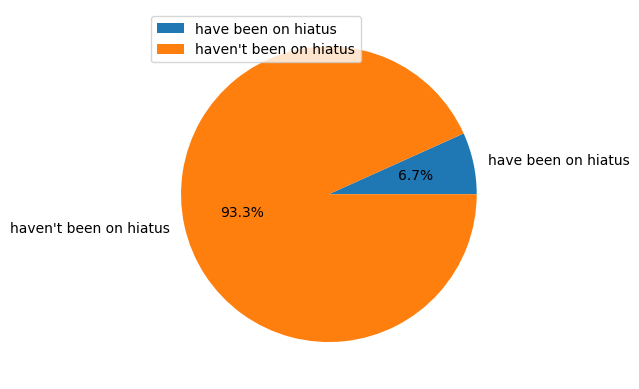

In [22]:
test.hiatus_pie_chart()

This may show that there is a significant amount of teenage boys reading manga as shonen appeals to that demographic

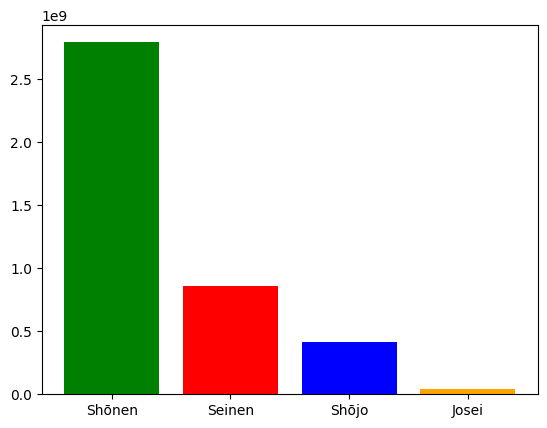

In [23]:
test.Demographic_bar_chart()

In [24]:
test.Average_Approximate(False)

"the value returned from the correlation calculation was 0.3 which isn't significant enough for there to be any calculation of regression to be done"

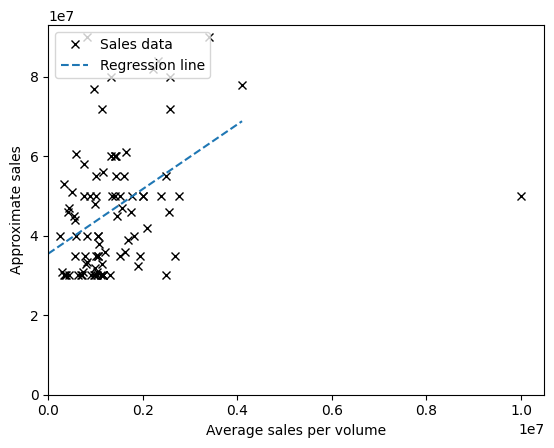

In [25]:
#here we show what it would look like if we performed the regression regardless of there being a correlation or not
test.Average_Approximate(True)

In [26]:
test.run_time('Captain Tsubasa')

'44 years'